In [116]:
#import
import time
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


***loading data***

In [117]:
X = pd.read_csv('feature_selection/X_selected.csv')
target = pd.read_csv('feature_selection/y.csv')
y = target['MEDV']

#standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# **ESOA** ***main code :***

In [118]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 23 14:35:31 2022

@author: 山抹微云
"""
# In[]
import numpy as np



# In[]
class ESO:
    def __init__(self, func, n_dim, size_pop, max_iter, lb, ub, constraint_ueq=None):

        self.func     = func

        self.n_dim    = n_dim
        self.size_pop = size_pop
        self.max_iter = max_iter
        self.lb   = np.array(lb)
        self.ub   = np.array(ub)

        # adam's learning rate of weight estimate
        self.beta1 = 0.9
        self.beta2 = 0.99
        self.m = np.zeros((self.size_pop, self.n_dim))
        self.v = np.zeros((self.size_pop, self.n_dim))
        self.w = np.random.uniform(-1, 1, size=(self.size_pop, self.n_dim))
        self.g = np.empty_like(self.w)

        # location, fitness, and estimate fitness
        self.x = np.random.uniform(0, 1, size=(self.size_pop, self.n_dim)) * (self.ub-self.lb) + self.lb
        self.y = np.empty(self.size_pop)
        self.p_y = self.y.copy()

        # best fitness history and estimate error history
        self.y_hist = []
        self.err = []

        # individual best location, gradient direction, and fitness
        self.x_hist_best = self.x.copy()
        self.g_hist_best = np.empty_like(self.x)
        self.y_hist_best = np.ones(size_pop)*np.inf

        # group best location, gradient direction, and fitness
        self.x_global_best = self.x[0].copy()
        self.g_global_best = np.zeros(self.n_dim)
        self.y_global_best = func(self.x[0])

        self.hop = self.ub - self.lb

    def differential_evolution_mutation(self, idx, F=0.5, CR=0.9):
        idxs = [i for i in range(self.size_pop) if i != idx]
        a, b, c = self.x[np.random.choice(idxs, 3, replace=False)]
        mutant = a + F * (b - c)
        mutant = self.checkBound(mutant)

        trial = np.copy(self.x[idx])
        jrand = np.random.randint(self.n_dim)
        for j in range(self.n_dim):
            if np.random.rand() < CR or j == jrand:
                trial[j] = mutant[j]

        f_trial = self.func(trial)
        if f_trial < self.y[idx]:
            self.x[idx] = trial
            self.y[idx] = f_trial

    def checkBound(self,x):
        return np.clip(x, self.lb, self.ub)


    def refill(self,V):
        V = V.reshape(len(V), 1)
        V = np.tile(V, self.n_dim)
        return V

    def gradientEstimate(self, g_temp):

        # Indivual direction
        p_d = self.x_hist_best - self.x
        p_d_sum = p_d.sum(axis=1)
        p_d_sum = self.refill(p_d_sum)
        f_p_bias = self.y_hist_best - self.y
        f_p_bias = self.refill(f_p_bias)
        p_d *= f_p_bias
        p_d /= (p_d_sum+np.spacing(1))*(p_d_sum+np.spacing(1))

        d_p = p_d + self.g_hist_best

        # Group direction
        c_d = self.x_global_best - self.x
        c_d_sum = c_d.sum(axis=1)
        c_d_sum = self.refill(c_d_sum)
        f_c_bias = self.y_global_best - self.y
        f_c_bias = self.refill(f_c_bias)
        c_d *= f_c_bias
        c_d /= (c_d_sum+np.spacing(1))*(p_d_sum+np.spacing(1))

        d_g = c_d + self.g_global_best

        # Advice
        r1 = np.random.random(self.size_pop)
        r1 = self.refill(r1)

        r2 = np.random.random(self.size_pop)
        r2 = self.refill(r2)

        r3 = np.random.random(self.size_pop)
        r3 = self.refill(r3)

        self.g = r1 * g_temp + r2 * d_p + r3 * d_g
        g_sum = self.g.sum(axis=1)
        g_sum = self.refill(g_sum)
        self.g /= (g_sum+np.spacing(1))

    def weightUpdate(self):
        # Update weight
        self.m = self.beta1*self.m+(1-self.beta1)*self.g
        self.v = self.beta2*self.v+(1-self.beta2)*self.g**2
        self.w = self.w - self.m/(np.sqrt(self.v)+np.spacing(1))

    def updateSurface(self):
        self.y = np.array([self.func(self.x[i, :]) for i in range(self.size_pop)]).reshape(self.size_pop)
        self.p_y = np.sum(self.w*self.x, axis=1)
        self.err.append(np.abs(self.y-self.p_y).min())
        p = self.p_y-self.y
        p = self.refill(p)
        g_temp = p*self.x

        mask = self.y < self.y_hist_best
        self.y_hist_best = np.where(mask, self.y, self.y_hist_best)

        mask = self.refill(mask)
        self.x_hist_best = np.where(mask, self.x, self.x_hist_best)
        self.g_hist_best = np.where(mask, g_temp, self.g_hist_best)

        g_hist_sum = self.refill(np.sqrt((self.g_hist_best**2).sum(axis=1)))
        self.g_hist_best /= (g_hist_sum + np.spacing(1))

        # Data Insecure
        if self.y.min() < self.y_global_best:
            self.y_global_best = self.y.min()
            self.x_global_best = self.x[self.y.argmin(), :]
            self.g_global_best = g_temp[self.y.argmin(), :]
            self.g_global_best /= np.sqrt(np.sum(self.g_global_best**2))

        self.gradientEstimate(g_temp)

        self.weightUpdate()



    def randomSearch(self):
        # Random search
        r = np.random.uniform(-np.pi / 2, np.pi / 2, size=(self.size_pop, self.n_dim))
        x_n = self.x + np.tan(r) * self.hop/( 1 + self.times) *0.5

        x_n = self.checkBound(x_n)


        y_n = np.array([self.func(x_n[i, :]) for i in range(self.size_pop)])

        # Random step search
        d = self.x_hist_best - self.x
        d_g = self.x_global_best - self.x
        #r = np.random.uniform(-np.pi / 2, np.pi / 2, size=(size_pop, n_dim))
        r = np.random.uniform(0, 0.5, size=(self.size_pop, self.n_dim))
        r2 = np.random.uniform(0, 0.5, size=(self.size_pop, self.n_dim))
        x_m = (1-r-r2) * self.x + r * d + r2 * d_g
        x_m = self.checkBound(x_m)


        y_m = np.array([self.func(x_m[i, :]) for i in range(self.size_pop)])

        return x_m, y_m, x_n, y_n


    def adviceSearch(self):
        x_o = self.x + np.exp(-self.times/(0.1*self.max_iter)) * 0.1 * self.hop * self.g
        x_o = self.checkBound(x_o)


        y_o = np.array([self.func(x_o[i, :]) for i in range(self.size_pop)])
        return x_o, y_o


    def run(self, verbose=True, csv_filename="eso_de_log.csv"):
        start_time = time.time()
        
        # CSV setup
        header = ["Iteration", "Best_Fitness", "Elapsed_Time", "Estimated_Total_Time"]
        if os.path.exists(csv_filename):
            os.remove(csv_filename)
        with open(csv_filename, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(header)

        for self.times in range(self.max_iter):
            if self.times % 5 == 0:
                worst_indices = np.argsort(-self.y)[:max(1, int(self.size_pop * 0.2))]
                for idx in worst_indices:
                    self.differential_evolution_mutation(idx)
            iter_start = time.time()

            self.updateSurface()
            x_m, y_m, x_n, y_n = self.randomSearch()
            x_o, y_o = self.adviceSearch()
            
            # Comparison
            x_i = np.empty_like(self.x)
            y_i = np.empty_like(self.y)
            x_summary = np.array([x_m, x_n, x_o])
            y_summary = np.column_stack((y_m, y_n, y_o))
            y_summary[np.isnan(y_summary)] = np.inf
            i_ind = y_summary.argmin(axis=1)
            for i in range(self.size_pop):
                y_i[i] = y_summary[i, i_ind[i]]
                x_i[i,:] = x_summary[i_ind[i]][i]

            # Update location
            mask = y_i < self.y
            self.y = np.where(mask, y_i, self.y)
            mask = self.refill(mask)
            self.x = np.where(mask, x_i, self.x)
            mask = y_i < self.y_hist_best
            self.y_hist_best = np.where(mask, y_i, self.y_hist_best)
            mask = self.refill(mask)
            self.x_hist_best = np.where(mask, x_i, self.x_hist_best)

            if y_i.min() < self.y_global_best:
                self.y_global_best = y_i[y_i.argmin()]
                self.x_global_best = x_i[y_i.argmin(), :]
            else:
                ran = np.random.random(self.size_pop)
                ran = self.refill(ran)
                ran[mask] = 1
                mask = ran < 0.3
                self.x = np.where(mask, x_i, self.x)
                self.y = np.where(mask[:, 0], y_i, self.y)

            self.y_hist.append(self.y_global_best.copy())

            # Timing & verbose output
            iter_time = time.time() - iter_start
            elapsed = time.time() - start_time
            estimated_total = (elapsed / (self.times + 1)) * self.max_iter
            if verbose:
                print(f"Iter {self.times + 1}/{self.max_iter} | Best Fitness: {self.y_global_best:.6f} | "
                      f"Iter Time: {iter_time:.2f}s | Elapsed: {elapsed:.2f}s | Est. Total: {estimated_total:.2f}s")

            # Write to CSV
            with open(csv_filename, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([self.times + 1, self.y_global_best, elapsed, estimated_total])
        return self.x_global_best, self.y_global_best, self.err

# model **SVR**

In [119]:
c = 1.0
e = 0.1
g = 0.1
model_svr = SVR(kernel='rbf', C=c, epsilon=e, gamma=g)

# Ensure the feature names match between X_train and X_test

model_svr.fit(X_train, y_train)

y_pred = model_svr.predict(X_test)


In [120]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R^2 score (accuracy)
accuracy = r2_score(y_test, y_pred)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (SVR without ESOA optimization): {mse}")
print(f"Accuracy Score (SVR without ESOA optimization): {accuracy} %")

Mean Squared Error (SVR without ESOA optimization): 19.332281781282678
Accuracy Score (SVR without ESOA optimization): 0.7363795927585206 %


# inserting **SVR** function to feed the ESOA 

In [121]:
def func(hyperparams):
    C, epsilon, gamma = hyperparams
    model = SVR(C=C, epsilon=epsilon, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [122]:
model = ESO(
    func=func,
    n_dim=3,
    size_pop=256,
    max_iter=75,
    lb = [0.1, 0.001 , 1e-5],
    ub = [100, 1, 10],

)


In [123]:
#running the model
best_params, best_score, err = model.run()

Iter 1/75 | Best Fitness: 8.502917 | Iter Time: 15.75s | Elapsed: 16.61s | Est. Total: 1245.46s
Iter 2/75 | Best Fitness: 8.502917 | Iter Time: 16.59s | Elapsed: 33.20s | Est. Total: 1244.91s
Iter 3/75 | Best Fitness: 8.502917 | Iter Time: 16.98s | Elapsed: 50.18s | Est. Total: 1254.50s
Iter 4/75 | Best Fitness: 8.479363 | Iter Time: 16.86s | Elapsed: 67.04s | Est. Total: 1257.00s
Iter 5/75 | Best Fitness: 8.469287 | Iter Time: 17.73s | Elapsed: 84.78s | Est. Total: 1271.63s
Iter 6/75 | Best Fitness: 8.469287 | Iter Time: 18.43s | Elapsed: 104.44s | Est. Total: 1305.49s
Iter 7/75 | Best Fitness: 8.469287 | Iter Time: 25.87s | Elapsed: 130.31s | Est. Total: 1396.21s
Iter 8/75 | Best Fitness: 8.469287 | Iter Time: 27.92s | Elapsed: 158.24s | Est. Total: 1483.47s
Iter 9/75 | Best Fitness: 8.469287 | Iter Time: 19.90s | Elapsed: 178.14s | Est. Total: 1484.47s
Iter 10/75 | Best Fitness: 8.469287 | Iter Time: 22.27s | Elapsed: 200.41s | Est. Total: 1503.04s
Iter 11/75 | Best Fitness: 8.46926

In [124]:
c = best_params[0]
e = best_params[1]
g = best_params[2]
ESOA_svr = SVR(kernel='rbf', C=c, epsilon=e, gamma=g)

ESOA_svr.fit(X_train, y_train)

y_pred_optimized = ESOA_svr.predict(X_test)

# Evaluate the optimized model
accuracy_optimized = ESOA_svr.score(X_test, y_test)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
print(f"Mean Squared Error (SVR with ESOA optimization): {mse_optimized}")
print(f"Accuracy Score (SVR with ESOA optimization): {accuracy_optimized} %")


Mean Squared Error (SVR with ESOA optimization): 8.441748864913553
Accuracy Score (SVR with ESOA optimization): 0.8848859488612755 %


In [125]:
diff = (accuracy_optimized - accuracy)* 100
print(f"diff in Accuracy: {diff:.2f} %")

improvement = (accuracy_optimized - accuracy) / accuracy * 100
print(f"Improvement in Accuracy: {improvement:.2f} %")

diff in Accuracy: 14.85 %
Improvement in Accuracy: 20.17 %


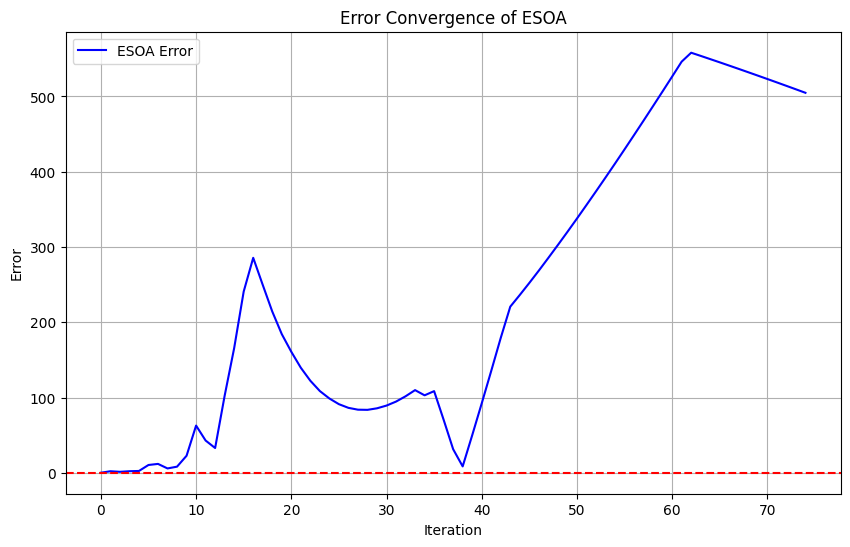

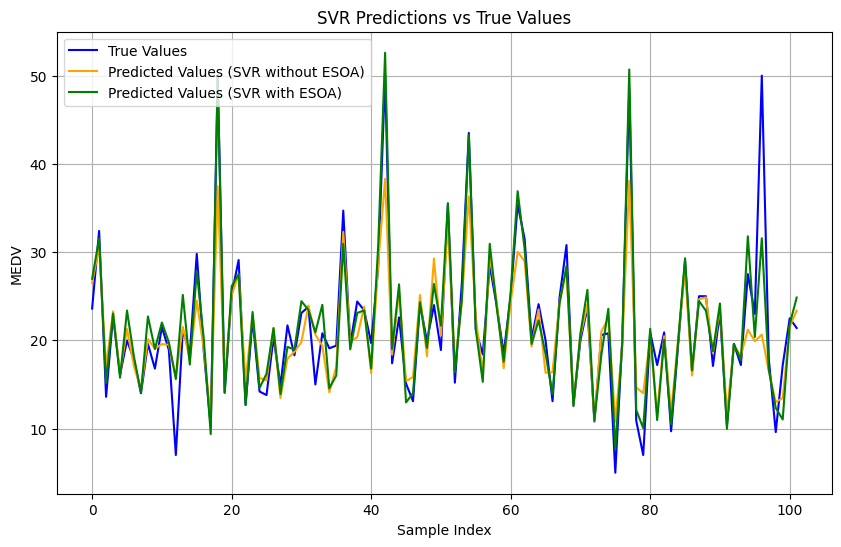

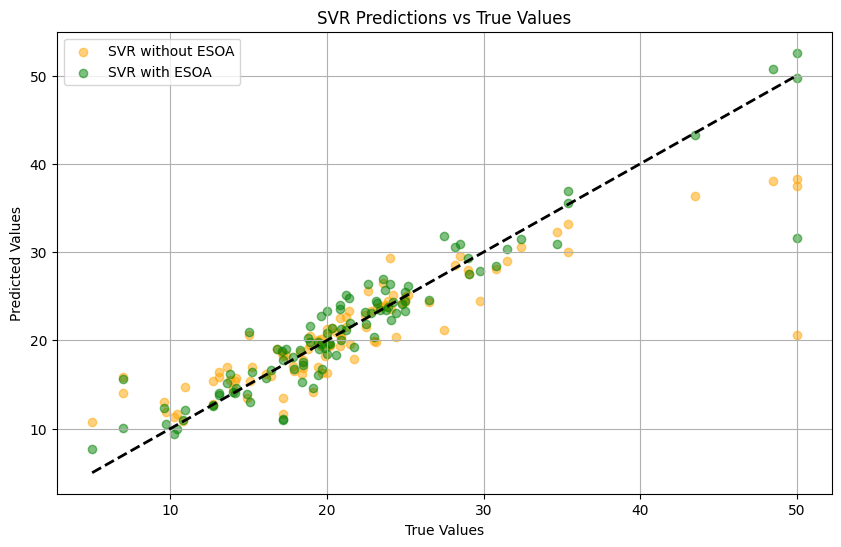

In [126]:
plt.figure(figsize=(10, 6))
plt.plot(err, label='ESOA Error', color='blue')
plt.title('Error Convergence of ESOA') 
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values', color='blue')
plt.plot(y_pred, label='Predicted Values (SVR without ESOA)', color='orange')
plt.plot(y_pred_optimized, label='Predicted Values (SVR with ESOA)', color='green')
plt.title('SVR Predictions vs True Values')
plt.xlabel('Sample Index')
plt.ylabel('MEDV')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label='SVR without ESOA', color='orange', alpha=0.5)
plt.scatter(y_test, y_pred_optimized, label='SVR with ESOA', color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('SVR Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()
